<a href="https://colab.research.google.com/github/ShesterG/Twitter-Sentiment-Analysis/blob/master/notebooks/rf_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Model for Twitter Sentiment Analysis

This model will use Multinomial Naive Bayes with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

Lemmatization will be applied to the dataset.

With SMOTE oversampling

With Bi-Grams, removing some common stop words that do not have a polarity associated with them.

# Imports and Constants

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelBinarizer
#import evaluation_functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer 
from imblearn.over_sampling import SMOTE
import ast



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import make_scorer

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
DATA_FILE_PATH = '/content/drive/MyDrive/NLPGh/'
CLEAN_DATA_FILE_NAME = 'Book10Clean.csv'
TOKENIZED_DATA_FILE_NAME = 'Book10Tokenized.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [5]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [6]:
df.head()

,Unnamed: 0,tweet,location_x,pretweet,candidate,LRPredScore,LRConfi,Sentiment,Unnamed: 8,tokens
0,2,"@NAkufoAddo H. E Nana please follow up on this FAKE NEWS, LIES and sue BBC for peddling false information. Hold alÃ¢â¬Â¦ https://t.co/SdwnMsxeUV",NaN,nana pleas follow thi fake new lie and sue bbc for peddl fals inform hold al,Nana,-3.0,1.0,0,NaN,"['nana', 'pleas', 'follow', 'thi', 'fake', 'new', 'lie', 'and', 'sue', 'bbc', 'for', 'peddl', 'fals', 'inform', 'hold', 'al']"
1,6,"@ChipsJhay @TruthFreema @AOuattara_PRCI @NAkufoAddo No, you haven't. He's using his freedom of speech as it is. He's covered.","Afamase Akotom, Ghana",no you havent he use hi freedom speech is he cover,Nana,NaN,NaN,0,NaN,"['no', 'you', 'havent', 'he', 'use', 'hi', 'freedom', 'speech', 'is', 'he', 'cover']"
2,7,@IssahGerard @HEgyiri @NAkufoAddo Please who is this and how is he your in law??,NaN,pleas who thi and how your law,Nana,-1.0,1.0,0,NaN,"['pleas', 'who', 'thi', 'and', 'how', 'your', 'law']"
3,17,@Kwame34580189 @bukolasaraki @NAkufoAddo Whatever.... Thought you had something there....,Nigeria,whatev thought you had someth there,Nana,NaN,NaN,0,NaN,"['whatev', 'thought', 'you', 'had', 'someth', 'there']"
4,18,@NAkufoAddo Remember that the good people of Gh have spoken therefore Soo be it,NaN,rememb that the good peopl have spoken therefor soo,Nana,1.0,1.0,0,NaN,"['rememb', 'that', 'the', 'good', 'peopl', 'have', 'spoken', 'therefor', 'soo']"


In [7]:
#df = df[df.Sentiment != 0]

In [8]:
df.tokens = df.tokens.map(ast.literal_eval)

In [9]:
data = df[['tokens', 'Sentiment']]

In [10]:
df.value_counts(["candidate", "Sentiment"])

candidate  Sentiment
Nana        0           853
            1           500
           -1           500
John        1           500
           -1           500
            0           147
dtype: int64

In [11]:

data.Sentiment.value_counts()

 1    1000
-1    1000
 0    1000
Name: Sentiment, dtype: int64

In [12]:
data.head()

,tokens,Sentiment
0,"[nana, pleas, follow, thi, fake, new, lie, and, sue, bbc, for, peddl, fals, inform, hold, al]",0
1,"[no, you, havent, he, use, hi, freedom, speech, is, he, cover]",0
2,"[pleas, who, thi, and, how, your, law]",0
3,"[whatev, thought, you, had, someth, there]",0
4,"[rememb, that, the, good, peopl, have, spoken, therefor, soo]",0


# Split Data

In [13]:
"""
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['Sentiment'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['Sentiment'])
"""

X = data['tokens']
y = data['Sentiment']

# Encode Labels

In [14]:
le = LabelEncoder()

In [15]:
y_enc = le.fit_transform(y)

# Evaluate Adjustments to Minimum Document Frequency

In [16]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc]

In [17]:
class stop_word_remover:
    def __init__(self):
         self.stop_words = frozenset(['the', 'to', 'at', 'rt', 'for', 'a', 
                                      'in', 'is', 'of', 'and', 'on', 'i', 
                                      'you', 'an', 'with', 'it', 'this'])
    def __call__(self, doc):
        return [t for t in doc if t not in self.stop_words]

In [18]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [19]:
def train_and_eval_model(min_df, ngram_range):
    """
    Train and Evaluate and Bag of Words Representation with a Naive Bayes
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([
                        ('bow',CountVectorizer(min_df=min_df,
                                               ngram_range=ngram_range,
                                               max_features=10000,
                                               analyzer='word',
                                               preprocessor=stop_word_remover(),
                                               tokenizer=LemmaTokenizer(), 
                                               lowercase=False)),  
                        ('tfidf', TfidfTransformer()),
                        ('smote', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
                        ('rf_classifier', RandomForestClassifier(random_state=RANDOM_STATE))])
    
     


    """
    pipeline_lr = Pipeline([('Scaler1', StandardScaler()),
                       ('lr_classifier', LogisticRegression(random_state=0))])



    pipeline.fit(X_train,y_train_enc)
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    y_pred = pipeline.predict(X_test)



    conf_matrix = confusion_matrix(y_true=y_test_enc, y_pred=y_pred)
    #confusion_matrix(y_true=y_train_enc, y_pred=pipeline.predict(X_train),labels='Training')

    
    classi_report = classification_report(y_true=y_test_enc, y_pred=y_pred, target_names=['Negative', 'Neutral', 'Postive'])
    print(classi_report)

    
    lb = LabelBinarizer()
    lb.fit(y_test_enc)
    y_test_multi = lb.transform(y_test_enc)
    y_hat_test_multi = pipeline.predict_proba(X_test)
    
    #evaluation_functions.pr_curves(y_test_multi, y_hat_test_multi, le.classes_)
    
    train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
        
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy]),
                             recall_scores)
   
    return test_results, conf_matrix
    """

    scoring = {'accuracy' : make_scorer(accuracy_score),
               'f1_score' : make_scorer(f1_score, average = 'micro'), 
               'precision' : make_scorer(precision_score, average = 'micro'),
               'recall' : make_scorer(recall_score, average = 'micro') 
              }
    
    scores = cross_validate(pipeline, X, y_enc, cv=10, scoring=scoring)
    sorted(scores.keys())

    y_pred = cross_val_predict(pipeline, X, y_enc, cv=10)

    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    conf_matrix = confusion_matrix(y_true=y_enc, y_pred=y_pred)

    classi_report = classification_report(y_true=y_enc, y_pred=y_pred, digits=4, target_names=['Negative','Neutral','Postive'])
    print(classi_report)

    """
    #y_pred = cross_val_predict(Pipeline, X, Y, cv=10)
    
    
    #y_pred = pipeline.predict(X_test)



    #conf_matrix = confusion_matrix(y_true=y_test_enc, y_pred=y_pred)
    #confusion_matrix(y_true=y_train_enc, y_pred=pipeline.predict(X_train),labels='Training')

    
    #classi_report = classification_report(y_true=y_test_enc, y_pred=y_pred, target_names=['Negative', 'Postive'])
    #print(classi_report)
    ['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro',
 'train_prec_macro', 'train_rec_macro']

    
    #train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
    
    ave_macro_recall = recall_score(y_test_enc, pipeline.predict(X_test), average='macro')
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy, ave_macro_recall]),
                             recall_scores, score_mean)
    """
    a = scores['test_accuracy'].mean()
    f = scores['test_f1_score'].mean()
    p = scores['test_precision'].mean()
    r = scores['test_recall'].mean()
    test_results = np.append(np.array([min_df, a, f, p]),r)
    
    
   
    return test_results, conf_matrix, y_pred 
    

In [20]:
metrics_summary = []

for min_df in range(1,11):
    test_scores, conf_matrix, y_pred = train_and_eval_model(min_df, (1,2))
    metrics_summary.append(test_scores)

MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.7660    0.5370    0.6314      1000
     Neutral     0.5720    0.7470    0.6479      1000
     Postive     0.7281    0.7230    0.7255      1000

    accuracy                         0.6690      3000
   macro avg     0.6887    0.6690    0.6683      3000
weighted avg     0.6887    0.6690    0.6683      3000

MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative     0.7116    0.5700    0.6330      1000
     Neutral     0.5831    0.6880    0.6312      1000
     Postive     0.7085    0.7220    0.7152      1000

    accuracy                         0.6600      3000
   macro avg     0.6677    0.6600    0.6598      3000
weighted avg     0.6677    0.6600    0.6598      3000

MINIMUM DOCUMENT FREQUENCY = 3

              precision    recall  f1-score   support

    Negative     0.7195    0.5950    0.6513      1000
     Neutral     0.5828    0.6720

In [21]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'accuracy',
                                           'f1_score',
                                           'precision',
                                          'recall'
                                          ])

metrics_summary_df

,min doc freq,accuracy,f1_score,precision,recall
0,1.0,0.669000,0.669000,0.669000,0.669000
1,2.0,0.660000,0.660000,0.660000,0.660000
2,3.0,0.664667,0.664667,0.664667,0.664667
3,4.0,0.673333,0.673333,0.673333,0.673333
4,5.0,0.662333,0.662333,0.662333,0.662333
5,6.0,0.661000,0.661000,0.661000,0.661000
6,7.0,0.660667,0.660667,0.660667,0.660667
7,8.0,0.659667,0.659667,0.659667,0.659667
8,9.0,0.661333,0.661333,0.661333,0.661333
9,10.0,0.657333,0.657333,0.657333,0.657333


MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative     0.7116    0.5700    0.6330      1000
     Neutral     0.5831    0.6880    0.6312      1000
     Postive     0.7085    0.7220    0.7152      1000

    accuracy                         0.6600      3000
   macro avg     0.6677    0.6600    0.6598      3000
weighted avg     0.6677    0.6600    0.6598      3000



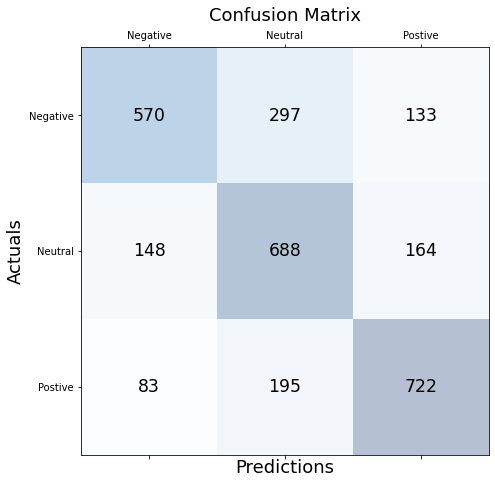

In [22]:
#metrics = train_and_eval_model(min_df=7, ngram_range=(1,2))

test_results, conf_matrix, y_pred = train_and_eval_model(min_df=2, ngram_range=(1,2))
labels = ['Negative','Neutral', 'Postive']

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Summary

SVM looks better
